# Only need to execute this notebook in kaggle 
We trained the model, generated the prediction, then saved the output as submission.csv for scoring

In [37]:
import numpy as np
import pandas as pd
import cv2
import torchvision.transforms as transforms
import time
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import gc # aarbage collector to clean uesless data from memory

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# have checked that we can appropriately ignore warnings
import warnings
warnings.filterwarnings('ignore') # ignore warnings

### Set up the array generating function for later usage

In [4]:
# for test set
# declare our image dimensions using color images

img_size = 250
channels = 3  # change to 1 if need to use grayscale image

# define function to read and process the images to an acceptable format for our model
def read_and_process_image_test(list_of_images):
    X = [] # an array of resized images
    for i, image in enumerate(list_of_images):
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (img_size, img_size), interpolation=cv2.INTER_CUBIC)) # read the image

    return X

# Load in the training array and label
We have to up load them to the input section of kaggle notebook first, so we can load the preprocessed training set array:   
1. image size = 250 pixel * 250 pixels  
2. The categorical label has already been preprocessed using one hot encoding

In [38]:
X_TRAIN = np.load("/kaggle/input/training250/training_X.npy", allow_pickle = True)
y_TRAIN = np.load("/kaggle/input/training250/training_y.npy", allow_pickle = True)

print("shape of train images:", X_TRAIN.shape)
print("shape of labels:", y_TRAIN.shape)

shape of train images: (9912, 250, 250, 3)
shape of labels: (9912,)


In [39]:
# split the data into train and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_TRAIN, y_TRAIN, test_size=0.20, random_state=2)

print("shape of train images:", X_train.shape)
print("shape of validation images:", X_val.shape)
print("shape of labels:", y_train.shape)
print("shape of labels:", y_val.shape)

shape of train images: (7929, 250, 250, 3)
shape of validation images: (1983, 250, 250, 3)
shape of labels: (7929,)
shape of labels: (1983,)


In [7]:
# set up small batch to avoid run out of memory when allocating
batch_size = 32

In [8]:
# clear memory
del X_TRAIN
del y_TRAIN
gc.collect()

0

# Image augmentation

In [10]:
# this would helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale = 1./255,   # scale the image between 0 and 1
                                   rotation_range = 60,
                                   width_shift_range = 1.0,
                                   height_shift_range = 1.0,
                                   shear_range = 0.4,
                                   zoom_range = [0.1, 2],
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode='nearest')


val_datagen = ImageDataGenerator(rescale = 1./255)  # do not augment validation data. we only perform rescale

# create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

# Import modules for model training

In [9]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Self-built CNN  

In [41]:
# define the function to create CNN model

def creat_model():
    
    model = keras.models.Sequential()

    # data_format='channels_last': so the channels(1 for grayscale/3 for RGB) will be the last dimension in input_shape
    # X_train should be: (batch_size, height, width, channels)
    # i.e., (training_data.shape[0], img_size, img_size, 1) since we have 25000 data

    # convolutional layer 1
    model.add(Conv2D(filters=32, kernel_size=3, data_format='channels_last', input_shape=(img_size, img_size, 3), padding='same', strides=1)) # filters=32: have 32 filters
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 2
    # after the 1st layer, don't need to specify the size of the input
    model.add(Conv2D(filters=64, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 3
    # after the 1st layer, don't need to specify the size of the input
    model.add(Conv2D(filters=128, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 4
    # after the 1st layer, don't need to specify the size of the input
    model.add(Conv2D(filters=256, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    # convolutional layer 5
    # after the 1st layer, don't need to specify the size of the input
    model.add(Conv2D(filters=512, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # flatten layer
    model.add(Flatten())

    # dense layer 1
    model.add(Dense(units=512))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    
    # dense layer 2
    model.add(Dense(units=256))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    
    # dense layer 3
    model.add(Dense(units=128))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.25))
    
    # dense layer 4
    model.add(Dense(units=64))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    
    # dense layer 5
    model.add(Dense(units=32))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    # dense layer 6, i.e. output layer (size=1 for regression)
    model.add(Dense(units=1, activation='relu'))

    # compile
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [ ]:
# define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=4,
                               restore_best_weights=True)

### In the model training phase, we only extract epochs from 8-30 and set early stop to avoid overfitting  
We did this by setting initial_epoch to get more stable outcome

In [42]:
# creat_model() will return a cnn model initial structure
model = creat_model() 

# train the model
history = model.fit(train_generator, 
                    steps_per_epoch = len(X_train) // batch_size, 
                    epochs=30, 
                    initial_epoch = 7,
                    validation_data=val_generator, 
                    validation_steps = len(X_val) // batch_size, 
                    callbacks=[early_stopping])

Epoch 8/30


2023-12-05 05:41:51.776630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


247/247 [==============================] - 135s 507ms/step - loss: 1657.9318 - root_mean_squared_error: 40.7177 - val_loss: 1548.3010 - val_root_mean_squared_error: 39.3485
Epoch 9/30
247/247 [==============================] - 124s 503ms/step - loss: 1191.9634 - root_mean_squared_error: 34.5248 - val_loss: 1158.0403 - val_root_mean_squared_error: 34.0300
Epoch 10/30
247/247 [==============================] - 125s 505ms/step - loss: 750.4642 - root_mean_squared_error: 27.3946 - val_loss: 666.8702 - val_root_mean_squared_error: 25.8238
Epoch 11/30
247/247 [==============================] - 125s 508ms/step - loss: 563.9544 - root_mean_squared_error: 23.7477 - val_loss: 492.6856 - val_root_mean_squared_error: 22.1965
Epoch 12/30
247/247 [==============================] - 127s 513ms/step - loss: 511.8406 - root_mean_squared_error: 22.6239 - val_loss: 469.2993 - val_root_mean_squared_error: 21.6633
Epoch 13/30
247/247 [==============================] - 125s 504ms/step - loss: 513.8691 - root

### Save the model for future useage

In [ ]:
# save the entire model as a `.keras` zip archive
model.save('1204_my_model_8-30_epoch.keras')

### Visualize training and validation loss

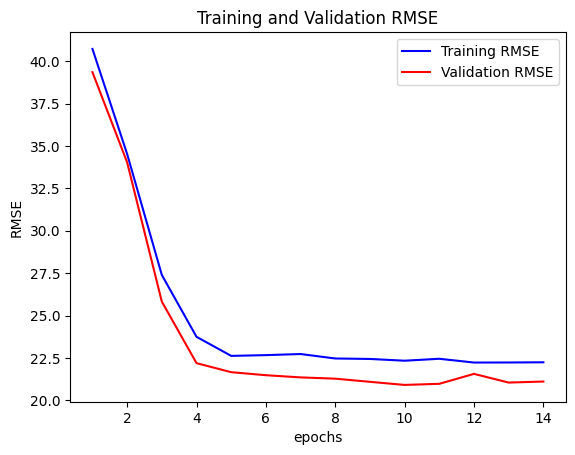

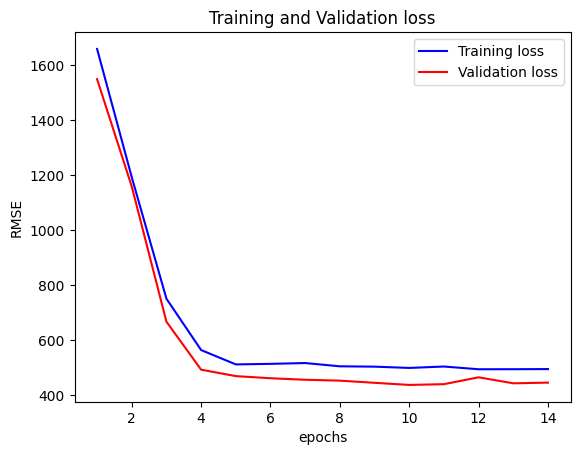

In [43]:
# plot the train and val curve

rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(rmse) + 1)

#Train and validation accuracy
plt.plot(epochs, rmse, 'b', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

### Summary for model training
1. Loss in train set and validation set decreased gradually in similar patterns as training epochs increase.  
2. The training process was interrupted by early stopping after 21 epochs, so we got 8-21 epochs.  
2. We can see that validation loss is around 21, which might not be good enough, so we want to try the pretrainined model under Keras structure.  

# Pretrained Keras model: EfficientNetB4 (version for regression)
### Among all the model we've tried (listed in the appendix), this model gave us the best result in test set
Since the submission of the notebook can't connect to the internet, we can't use the code like:  
"  pretrained_model = EfficientNetB4(include_top = False, weights = 'imagenet', input_shape=(img_size, img_size, 3)) "  
since this will need to connect to ImageNet to load the weight  

### Get the model path under kaggle notebook

In [14]:
model_name = "efficientnetv2-b4"

model_handle_map = {'efficientnetv2-b4': '/kaggle/input/efficientnet/tensorflow2/b4-feature-vector/1'}

model_image_size_map = {
  "efficientnetv2-b4": img_size,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, img_size)

print(f"selected model path: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"input size {IMAGE_SIZE}")

selected model path: efficientnetv2-b4 : /kaggle/input/efficientnet/tensorflow2/b4-feature-vector/1
input size (250, 250)


In [15]:
# check the imput shape
IMAGE_SIZE + (3,)

(250, 250, 3)

In [17]:
import tensorflow_hub as hub

model = tf.keras.Sequential([
    # explicitly define the input shape: (250, 250, 3)
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    
    # set trainable = True for fine tune
    hub.KerasLayer(model_handle, trainable = True),
    
    # dense layer 1
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 2
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 3
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("leaky_relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 4
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 5
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("leaky_relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 6
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 7
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 8
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 9
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 10
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("leaky_relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 11
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("leaky_relu"),
    tf.keras.layers.Dropout(0.6),
    
    # dense layer 12
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("leaky_relu"),
    tf.keras.layers.Dropout(0.7),
    
    # dense layer 13
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.25),
    
    # dense layer 14
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.25),
    
    # dense layer 15, output layer
    tf.keras.layers.Dense(units=1, activation='relu') # dimension for output is 1 for regression problem
])
model.build((None,)+IMAGE_SIZE+(3,))

# check the model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1792)              17673816  
                                                                 
 dense_11 (Dense)            (None, 32)                57376     
                                                                 
 batch_normalization_10 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 32)                0         
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                        

In [18]:
# compile the model, using 'mse' as loss function
# since this version is dealing with regression problem
model.compile(optimizer='nadam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

### In the model training phase, we only extract epochs from 8-30 and set early stop to avoid overfitting  
We did this by setting initial_epoch to get more stable outcome

In [20]:
# train the model
# we still use the early stopping as defined previously
history = model.fit(
    train_generator, 
    steps_per_epoch = len(X_train) // batch_size, 
    epochs=30, 
    initial_epoch = 7,
    validation_data=val_generator, 
    validation_steps = len(X_val) // batch_size, 
    callbacks=[early_stopping])

Epoch 8/30
247/247 [==============================] - 314s 590ms/step - loss: 1669.7002 - root_mean_squared_error: 40.8588 - val_loss: 1848.7576 - val_root_mean_squared_error: 42.9941
Epoch 9/30
247/247 [==============================] - 141s 567ms/step - loss: 1192.0747 - root_mean_squared_error: 34.5226 - val_loss: 80995.6250 - val_root_mean_squared_error: 284.5968
Epoch 10/30
247/247 [==============================] - 141s 571ms/step - loss: 717.9319 - root_mean_squared_error: 26.7892 - val_loss: 583.4852 - val_root_mean_squared_error: 24.1498
Epoch 11/30
247/247 [==============================] - 141s 569ms/step - loss: 506.7095 - root_mean_squared_error: 22.5041 - val_loss: 426.6828 - val_root_mean_squared_error: 20.6496
Epoch 12/30
247/247 [==============================] - 139s 560ms/step - loss: 468.0057 - root_mean_squared_error: 21.6270 - val_loss: 427.3836 - val_root_mean_squared_error: 20.6665
Epoch 13/30
247/247 [==============================] - 140s 566ms/step - loss: 47

### Save the model for future useage

In [24]:
# save the entire model as a `.keras` zip archive
model.save('/kaggle/working/1204_efficientnetv2-b4_8-30_epochs_early_stop.keras')

### Visualize training and validation loss

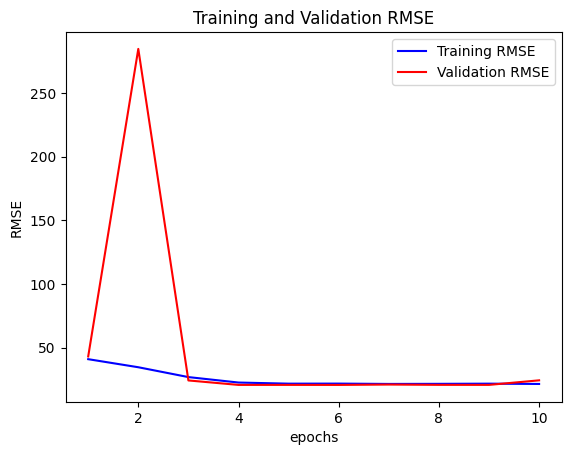

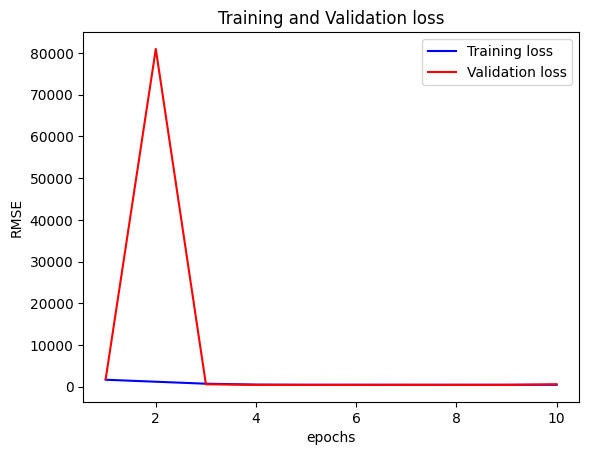

In [23]:
# plot the train and val curve

rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(rmse) + 1)

#Train and validation accuracy
plt.plot(epochs, rmse, 'b', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

### Summary for model training
1. Loss in training set and validation set follows similar patterns, both skyrocket in the second epoch and falls back.  
   That's why we don't want to use the first several epochs; they are unstable.  
2. The training process was interrupted by early stopping after 21 epochs, so we got 8-21 epochs.  
3. The performance in RMSE is better than self-built CNN since they are around 20 (just interrupt when rising to 24).  
   So we decided to use this model for prediction.  

# Do prediciton on testing set

In [25]:
# load the model for next time
reloaded_model = tf.keras.models.load_model('/kaggle/working/1204_efficientnetv2-b4_8-30_epochs_early_stop.keras')

### Read in testing images

In [26]:
test_dir = '/kaggle/input/petfinder-pawpularity-score/test'
test_imgs = ['/kaggle/input/petfinder-pawpularity-score/test/{}'.format(i) for i in os.listdir(test_dir)] # get test images

In [27]:
# process the test set
X_test = read_and_process_image_test(test_imgs) 

# convert list to numpy array
X_test = np.array(X_test)

# augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test) # after rescaling for the colors

### Set up Id for DataFrame building

In [28]:
Id = []

for i in range(len(test_imgs)):
    id = test_imgs[i].split('test/')[1].split('.')[0]
    Id.append(id)

In [29]:
Id

['c978013571258ed6d4637f6e8cc9d6a3',
 '4e429cead1848a298432a0acad014c9d',
 '43a2262d7738e3d420d453815151079e',
 '8f49844c382931444e68dffbe20228f4',
 '4128bae22183829d2b5fea10effdb0c3',
 '80bc3ccafcc51b66303c2c263aa38486',
 'e0de453c1bffc20c22b072b34b54e50f',
 'b03f7041962238a7c9d6537e22f9b017']

### Predict on test set

In [30]:
outcome = reloaded_model.predict(test_generator)

1/1 [==============================] - 3s 3s/step


### Construct the Pawpularity array to record the scores

In [31]:
Pawpularity = []

for i in range(len(test_imgs)):
    pawpularity = outcome[i].item()
    Pawpularity.append(pawpularity)

In [32]:
Pawpularity

[38.98554611206055,
 38.98340606689453,
 38.982887268066406,
 38.971656799316406,
 38.984466552734375,
 38.98414611816406,
 38.97465133666992,
 38.986270904541016]

### Now let's build the dataframe to save as a csv file

In [35]:
dic = {'Id': Id, 'Pawpularity': Pawpularity}
result = pd.DataFrame(dic)
result.head(10)

,Id,Pawpularity
0,c978013571258ed6d4637f6e8cc9d6a3,38.985546
1,4e429cead1848a298432a0acad014c9d,38.983406
2,43a2262d7738e3d420d453815151079e,38.982887
3,8f49844c382931444e68dffbe20228f4,38.971657
4,4128bae22183829d2b5fea10effdb0c3,38.984467
5,80bc3ccafcc51b66303c2c263aa38486,38.984146
6,e0de453c1bffc20c22b072b34b54e50f,38.974651
7,b03f7041962238a7c9d6537e22f9b017,38.986271


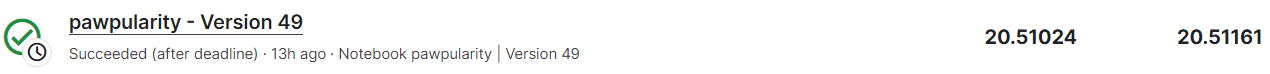

### The grade we get in the end, the best among all other models we've tried

In [36]:
# save the DataFrame to a csv file for submission
result.to_csv('submission.csv', index=False)

# This is the end of the notebook